In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np

from pathlib import Path 

from helper_functions import plot_predictions, plot_decision_boundary, plot_functions

In [2]:
digits = load_digits()
digits_df = pd.DataFrame(digits.data) # Converts the data into  pandas dataframe for easy access
digits_df["target"] = digits.target
digits_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0,5
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0,6
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0,9


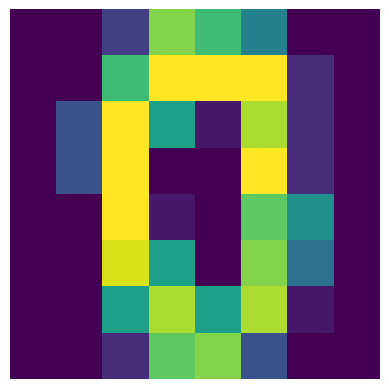

In [3]:
fig, axes = plt.subplots()
axes.imshow(digits.images[20])
axes.axis('off')
plt.show()

In [4]:
X = digits.data
y = digits.target

In [5]:
#training and test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Shuffled data

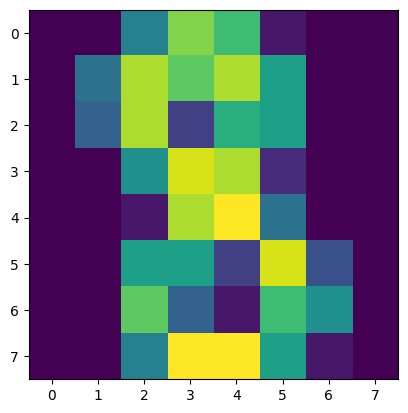

In [6]:
import numpy as np

fig, ax = plt.subplots()
ax.imshow(X_train[25].reshape(8,8))
plt.show()

In [7]:
X_train, X_test, y_train, y_test = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float), torch.tensor(y_train), torch.tensor(y_test)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1437, 64]),
 torch.Size([360, 64]),
 torch.Size([1437]),
 torch.Size([360]))

In [9]:
# Model
class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=64, out_features=108)
        self.ReLU = nn.ReLU()
        self.layer2 = nn.Linear(in_features=108, out_features=216)
        self.ReLU = nn.ReLU()
        self.layer3 = nn.Linear(in_features=216, out_features=10)
        self.ReLU = nn.ReLU()

    def forward(self, X):
        return self.layer3(self.ReLU(self.layer2(self.ReLU(self.layer1(X)))))

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def train(model, X_train, X_test, y_train, y_test, epochs= 1000, Learning_rate = 0.01):
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr= Learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    test_losses = []

    for epoch in range (epochs):
        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.softmax(y_logits, dim=1)
        y_pred_acc = torch.argmax(y_logits, dim = 1)

        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_pred_acc)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
      # 1. Forward pass
            test_logits = model(X_test).squeeze()
            test_pred = torch.softmax(test_logits, dim=1) # logits -> prediction probabilities -> prediction labels
            test_pred_acc = torch.argmax(test_logits, dim=1)
      # 2. Calculate loss and accuracy
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred_acc)
            test_loss.detach().cpu()
            test_losses.append(test_loss.item())
    # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    return test_losses

In [11]:
Model1 = MNIST()
losses = train(Model1, X_train, X_test, y_train, y_test, epochs=200, Learning_rate = 0.015)

Epoch: 0 | Loss: 2.91550, Accuracy: 7.59% | Test Loss: 4.90813, Test Accuracy: 34.17%
Epoch: 10 | Loss: 0.43017, Accuracy: 84.20% | Test Loss: 0.43047, Test Accuracy: 85.28%
Epoch: 20 | Loss: 0.09428, Accuracy: 96.87% | Test Loss: 0.16240, Test Accuracy: 96.39%
Epoch: 30 | Loss: 0.03044, Accuracy: 99.30% | Test Loss: 0.11852, Test Accuracy: 96.67%
Epoch: 40 | Loss: 0.01250, Accuracy: 99.65% | Test Loss: 0.14200, Test Accuracy: 97.22%
Epoch: 50 | Loss: 0.00403, Accuracy: 100.00% | Test Loss: 0.14932, Test Accuracy: 96.67%
Epoch: 60 | Loss: 0.00178, Accuracy: 100.00% | Test Loss: 0.15209, Test Accuracy: 96.67%
Epoch: 70 | Loss: 0.00095, Accuracy: 100.00% | Test Loss: 0.15711, Test Accuracy: 96.67%
Epoch: 80 | Loss: 0.00061, Accuracy: 100.00% | Test Loss: 0.15607, Test Accuracy: 96.94%
Epoch: 90 | Loss: 0.00046, Accuracy: 100.00% | Test Loss: 0.15420, Test Accuracy: 96.94%
Epoch: 100 | Loss: 0.00037, Accuracy: 100.00% | Test Loss: 0.15428, Test Accuracy: 96.94%
Epoch: 110 | Loss: 0.00031,

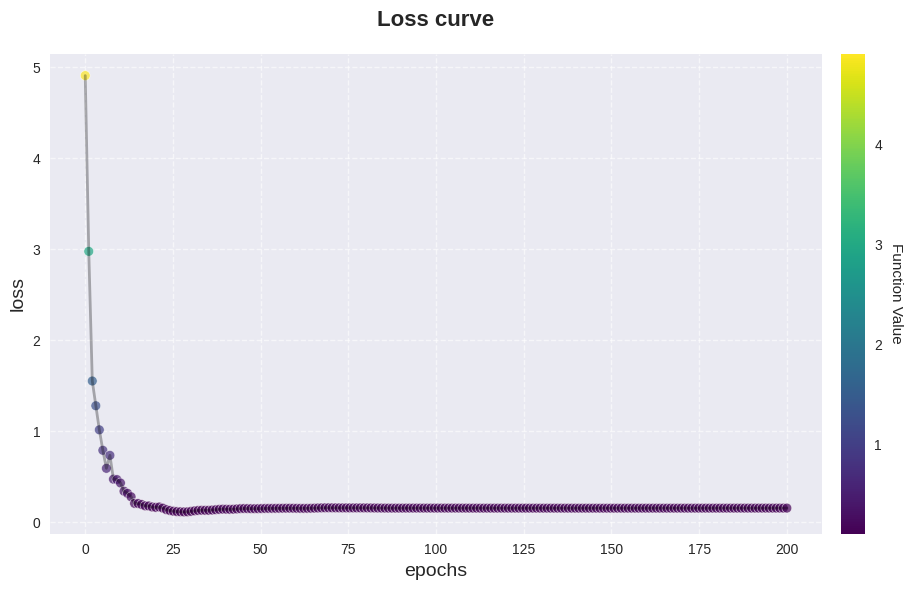

In [13]:
plt.show(plot_functions(losses, title="Loss curve", xlabel="epochs", ylabel="loss", x_range=(0,200)))